In [1]:
import os
import numpy as np
import copy
import seaborn as sn
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchnet.meter.confusionmeter as cm
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation & test

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandAugment(),
        # apply limited data augmentation methods randomly
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomRotation(degrees=(-10,10))]), p=0.2),
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomResizedCrop(224,(0.5,1))]), p=0.2),
        transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomHorizontalFlip()]), p=0.2),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# define basic variables

data_dir = 'marvel'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using K-fold cross validation with k = 3,
# set random state for the result to be re-producable
kf = KFold(n_splits=3, shuffle=True, random_state=114514)

batch_size = 16

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#Train the model

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {} in {}'.format(epoch +1, num_epochs))
        print('---' * 5)

        # Set train and valid phase for each epoch
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set to training mode
            else:
                model.eval()   # Set to evaluating mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]

            #For graph generation
            if phase == "train":
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                epoch_counter_train.append(epoch)
            if phase == "valid":
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                epoch_counter_val.append(epoch)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # final validation for each class
    phase = 'valid'
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    y_true = []
    y_pre = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            y_true.extend(labels.to('cpu'))
            y_pre.extend(preds.to('cpu'))
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # output the classification report
    # to check the F1 score for each class
    print(classification_report(y_true,y_pre))

    # for printing        
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss, epoch_acc


In [4]:
best_model_wts = None
init_model_wts = None
max_acc = -999

#Using a model pre-trained on ImageNet and replacing it's final linear layer
#For resnet18 or resnet50
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )
model_ft = model_ft.to(device)
init_model_wts = copy.deepcopy(model_ft.state_dict())

# Using label smoothing for false-labeled input data
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay Learning rate by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# Using k-fold cross validation
for i, (train_index, val_index) in enumerate(kf.split(image_datasets['train'])):

    train = torch.utils.data.Subset(image_datasets['train'], train_index)
    val = torch.utils.data.Subset(image_datasets['train'], val_index)

    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)

    # load images in 'valid' folder as test data
    testloader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size,
                                                shuffle=True, num_workers=4)

    dataloaders = {'train': trainloader, 'valid': valloader, 'test': testloader}
                                                
    dataset_sizes = {'train': len(train_index),
                    'valid': len(val_index),
                    'test': len(dataloaders['test'].dataset)}
                    
    #lists for graph generation
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    model_ft.load_state_dict(init_model_wts)
    optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

    # Decay Learning rate by a factor of 0.1 every 10 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
    
    model_ft, loss, acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, dataloaders = dataloaders, dataset_sizes = dataset_sizes)
    if (acc > max_acc):
        best_model_wts = copy.deepcopy(model_ft.state_dict())
        max_acc = acc
    


c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 in 50
---------------
train Loss: 1.8728 Acc: 0.3374
valid Loss: 2.0623 Acc: 0.2483

Epoch 2 in 50
---------------
train Loss: 1.7324 Acc: 0.4233
valid Loss: 2.8967 Acc: 0.2459

Epoch 3 in 50
---------------
train Loss: 1.6696 Acc: 0.4675
valid Loss: 1.8281 Acc: 0.3817

Epoch 4 in 50
---------------
train Loss: 1.5661 Acc: 0.5134
valid Loss: 2.0045 Acc: 0.3817

Epoch 5 in 50
---------------
train Loss: 1.4379 Acc: 0.5871
valid Loss: 1.5662 Acc: 0.5220

Epoch 6 in 50
---------------
train Loss: 1.3665 Acc: 0.6260
valid Loss: 1.7595 Acc: 0.4733

Epoch 7 in 50
---------------
train Loss: 1.3005 Acc: 0.6614
valid Loss: 1.6822 Acc: 0.4907

Epoch 8 in 50
---------------
train Loss: 1.2374 Acc: 0.6835
valid Loss: 1.4623 Acc: 0.5847

Epoch 9 in 50
---------------
train Loss: 1.1324 Acc: 0.7207
valid Loss: 1.7835 Acc: 0.4791

Epoch 10 in 50
---------------
train Loss: 1.0715 Acc: 0.7480
valid Loss: 1.5842 Acc: 0.5209

Epoch 11 in 50
---------------
train Loss: 0.9563 Acc: 0.8072
valid L

In [5]:

def plot_result():#Plot the train & validation losses
    plt.figure(1)
    plt.title("Training Vs Validation Losses")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
    plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
    plt.legend()
    plt.savefig('loss_smooth8.jpg')
    plt.show()

    #Plot the accuracies in train & validation
    plt.figure(2)
    plt.title("Training Vs Validation Accuracies")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
    plt.plot(epoch_counter_val,val_acc,color = 'g', label="Validation Accuracy")
    plt.legend()
    plt.savefig('acc_smooth8.jpg')
    plt.show()

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 59 %
Accuracy of black widow : 41 %
Accuracy of captain america : 43 %
Accuracy of doctor strange : 52 %
Accuracy of  hulk : 66 %
Accuracy of ironman : 53 %
Accuracy of  loki : 50 %
Accuracy of spider-man : 77 %
Accuracy of thanos : 70 %
[[27  7  6  3  2  5  3  2]
 [ 7 25  4  4  9  2  1  5]
 [ 2  3 32  4  4  5  8  3]
 [ 3  4  2 36  4  3  0  4]
 [ 1  6  2  6 34  0  3  4]
 [ 3  6  3  2  1 33  1  5]
 [ 2  3  1  1  2  1 45  2]
 [ 1  4  2  5  1  3  0 39]]


<AxesSubplot:>

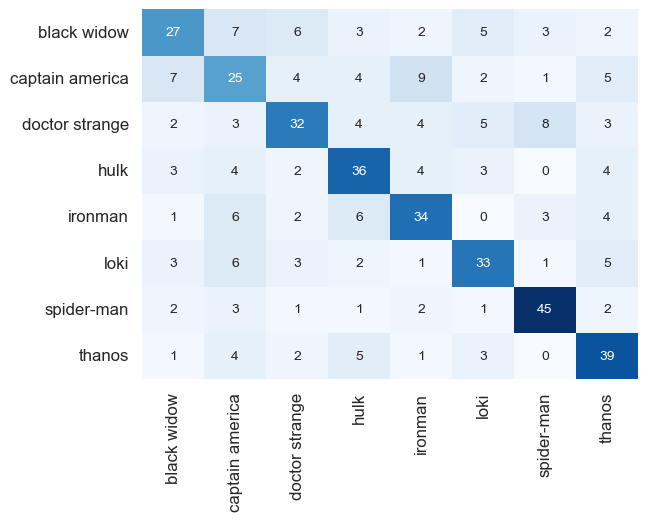

In [6]:
#Test the accuracy with original test data in 'valid' folder

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )
model_ft = model_ft.to(device)
model_ft.load_state_dict(best_model_wts)

correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

In [7]:
from skimage.util import random_noise

Accuracy with gaussian noise of mean 0 and std 0 on the test images: 60.09
Accuracy with gaussian noise of mean 0 and std 2 on the test images: 60.98
Accuracy with gaussian noise of mean 0 and std 4 on the test images: 57.21
Accuracy with gaussian noise of mean 0 and std 6 on the test images: 59.65
Accuracy with gaussian noise of mean 0 and std 8 on the test images: 58.76
Accuracy with gaussian noise of mean 0 and std 10 on the test images: 58.09
Accuracy with gaussian noise of mean 0 and std 12 on the test images: 59.65
Accuracy with gaussian noise of mean 0 and std 14 on the test images: 56.76
Accuracy with gaussian noise of mean 0 and std 16 on the test images: 56.54
Accuracy with gaussian noise of mean 0 and std 18 on the test images: 55.43
[0.6008869179600886, 0.6097560975609756, 0.5720620842572062, 0.5964523281596452, 0.5875831485587583, 0.5809312638580931, 0.5964523281596452, 0.5676274944567627, 0.565410199556541, 0.5543237250554324]


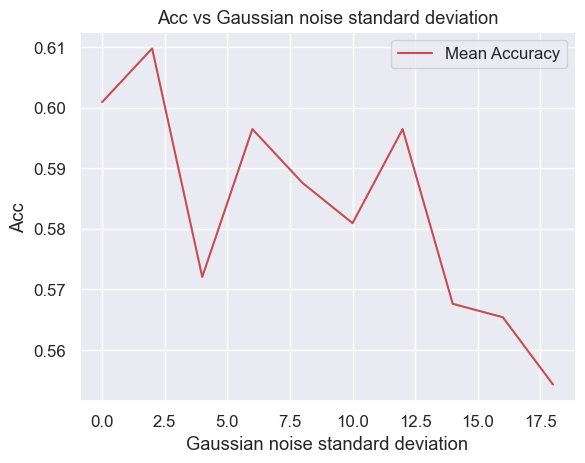

In [21]:
#Test the accuracy with test data after adding gaussian pixel noise
class AddGaussianNoise(object):
    def __init__(self, mean = 0., std = 1.):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        # generate gaussian noised image
        img = np.array(tensor)
        img_gau_noise = random_noise(img, mode='gaussian',mean = self.mean, var = (self.std/255)**2, clip=True)
        # convert to integers in range (0,255)
        img_gau_noise = (img_gau_noise*255).astype(np.int16)
        # convert to type 'float' in range (0,1) as required by following functions 
        img_gau_noise = (img_gau_noise).astype(np.float32)
        tensor_new = torch.from_numpy(img_gau_noise/255)
        return tensor_new

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean,self.std)

std_gau = [0,2,4,6,8,10,12,14,16,18]
acc_gau = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

model_ft = model_ft.to(device)

for std in std_gau:
    model_ft.load_state_dict(best_model_wts)

    gaussian_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AddGaussianNoise(mean=0, std=std),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_gaussian_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), gaussian_transform)

    testloader_gau = torch.utils.data.DataLoader(test_gaussian_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_gau):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with gaussian noise of mean 0 and std {0} on the test images: {1:.2f}'.format(
        std ,100 * correct / total))
    acc_gau.append(correct / total)

print(acc_gau)
plt.figure(1)
plt.title("Acc vs Gaussian noise standard deviation")
plt.xlabel('Gaussian noise standard deviation')
plt.ylabel('Acc')
plt.plot(std_gau,acc_gau,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_gau.jpg')
plt.show()

Accuracy with 0 times of gaussian blur on the test images: 61.86
Accuracy with 1 times of gaussian blur on the test images: 60.98
Accuracy with 2 times of gaussian blur on the test images: 59.20
Accuracy with 3 times of gaussian blur on the test images: 57.65
Accuracy with 4 times of gaussian blur on the test images: 57.65
Accuracy with 5 times of gaussian blur on the test images: 57.87
Accuracy with 6 times of gaussian blur on the test images: 56.76
Accuracy with 7 times of gaussian blur on the test images: 58.54
Accuracy with 8 times of gaussian blur on the test images: 55.88
Accuracy with 9 times of gaussian blur on the test images: 55.21
[0.6186252771618626, 0.6097560975609756, 0.5920177383592018, 0.5764966740576497, 0.5764966740576497, 0.5787139689578714, 0.5676274944567627, 0.5853658536585366, 0.5587583148558758, 0.5521064301552107]


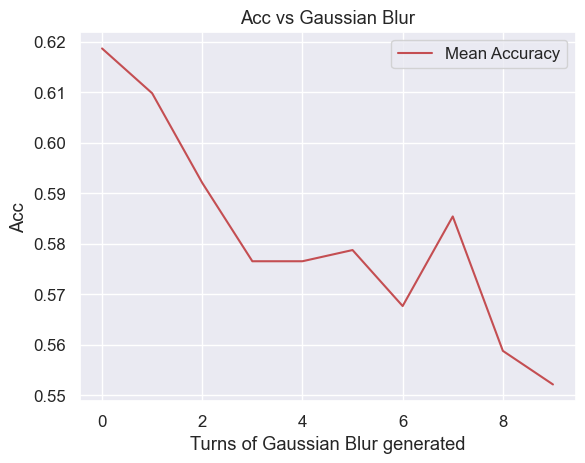

In [18]:
#Test the accuracy with test data after adding gaussian blur
class AddGaussianBlurs(object):
    def __init__(self, num=1.):
        self.num = num
        
    def __call__(self, tensor):
        # add gaussian blur for certain times
        img = tensor
        # set gaussian blur mask size to 3X3
        gau_blur = transforms.GaussianBlur(3)
        # add gaussian blur to the image tensor
        for i in range(self.num):
            img = gau_blur(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(num={0})'.format(self.num)

turns = range(10)
acc_gau_blur = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

model_ft = model_ft.to(device)


for num in turns:
    model_ft.load_state_dict(best_model_wts)

    gaussian_blur_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AddGaussianBlurs(num=num),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_gaussian_blur_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), gaussian_blur_transform)

    testloader_gau_blur = torch.utils.data.DataLoader(test_gaussian_blur_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_gau_blur):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with {0} times of gaussian blur on the test images: {1:.2f}'.format(
        num ,100 * correct / total))
    acc_gau_blur.append(correct / total)

print(acc_gau_blur)
plt.figure(1)
plt.title("Acc vs Gaussian Blur")
plt.xlabel('Turns of Gaussian Blur generated')
plt.ylabel('Acc')
plt.plot(turns,acc_gau_blur,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_gau_blur.jpg')
plt.show()

Accuracy with image contrast multipled by factor 1.0 on the test images: 59.20
Accuracy with image contrast multipled by factor 1.01 on the test images: 57.65
Accuracy with image contrast multipled by factor 1.02 on the test images: 59.20
Accuracy with image contrast multipled by factor 1.03 on the test images: 62.31
Accuracy with image contrast multipled by factor 1.04 on the test images: 60.53
Accuracy with image contrast multipled by factor 1.05 on the test images: 59.20
Accuracy with image contrast multipled by factor 1.1 on the test images: 58.09
Accuracy with image contrast multipled by factor 1.15 on the test images: 58.98
Accuracy with image contrast multipled by factor 1.2 on the test images: 60.53
Accuracy with image contrast multipled by factor 1.25 on the test images: 61.42
[0.5920177383592018, 0.5764966740576497, 0.5920177383592018, 0.623059866962306, 0.6053215077605322, 0.5920177383592018, 0.5809312638580931, 0.5898004434589801, 0.6053215077605322, 0.614190687361419]


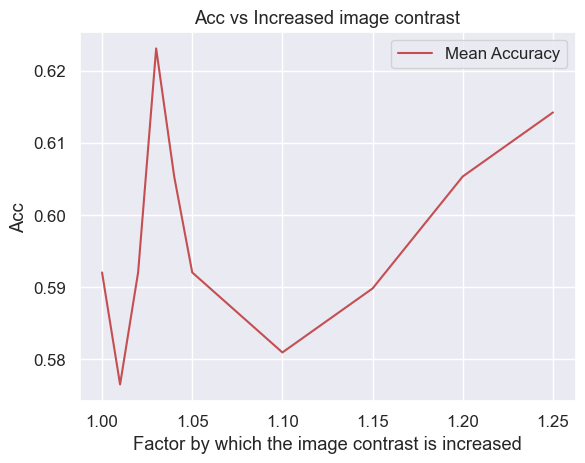

In [19]:
#Test the accuracy with test data after increasing the image contrast
class AdjustContrast(object):
    def __init__(self, factor=1.):
        self.factor = factor
        
    def __call__(self, tensor):
        img = np.array(tensor)
        # convert the values from (0,1) to (0,255)
        img = img * 255
        # adjust the contrast, and limit the pixel range in (0,255)
        img = np.clip(img*self.factor, 0, 255)
        img_tensor = torch.from_numpy(img/255)
        return img_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(factor={0})'.format(self.factor)

acc_contrast = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

factors = [1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.15, 1.20, 1.25]
model_ft = model_ft.to(device)

for n in factors:
    model_ft.load_state_dict(best_model_wts)

    contrast_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AdjustContrast(n),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_contrast_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), contrast_transform)

    testloader_contrast = torch.utils.data.DataLoader(test_contrast_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_contrast):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with image contrast multipled by factor {0} on the test images: {1:.2f}'.format(
        n ,100 * correct / total))
    acc_contrast.append(correct / total)

print(acc_contrast)
plt.figure(1)
plt.title("Acc vs Increased image contrast")
plt.xlabel('Factor by which the image contrast is increased')
plt.ylabel('Acc')
plt.plot(factors,acc_contrast,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_contrast_in.jpg')
plt.show()

Accuracy with image contrast multipled by factor 1.0 on the test images: 60.53
Accuracy with image contrast multipled by factor 0.95 on the test images: 57.87
Accuracy with image contrast multipled by factor 0.9 on the test images: 57.21
Accuracy with image contrast multipled by factor 0.85 on the test images: 59.20
Accuracy with image contrast multipled by factor 0.8 on the test images: 58.76
Accuracy with image contrast multipled by factor 0.6 on the test images: 57.87
Accuracy with image contrast multipled by factor 0.4 on the test images: 59.65
Accuracy with image contrast multipled by factor 0.3 on the test images: 58.98
Accuracy with image contrast multipled by factor 0.2 on the test images: 53.88
Accuracy with image contrast multipled by factor 0.1 on the test images: 54.77
[0.6053215077605322, 0.5787139689578714, 0.5720620842572062, 0.5920177383592018, 0.5875831485587583, 0.5787139689578714, 0.5964523281596452, 0.5898004434589801, 0.5388026607538803, 0.5476718403547672]


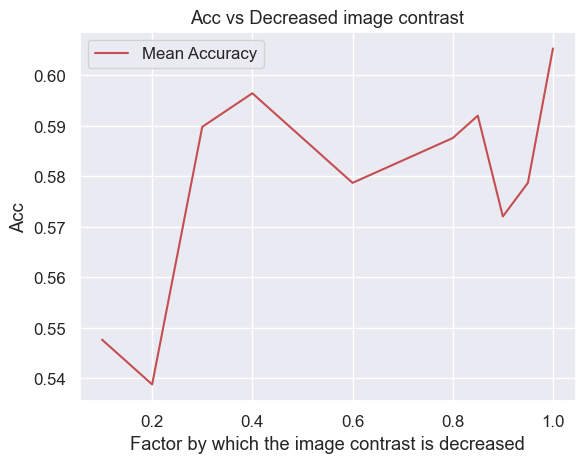

In [22]:
#Test the accuracy with test data after decreasing the image contrast
acc_contrast_de = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

factors_de = [1.0, 0.95, 0.90, 0.85, 0.80, 0.60, 0.40, 0.30, 0.20, 0.10]
model_ft = model_ft.to(device)

for n_de in factors_de:
    model_ft.load_state_dict(best_model_wts)

    contrast_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AdjustContrast(n_de),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_contrast_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), contrast_transform)

    testloader_contrast = torch.utils.data.DataLoader(test_contrast_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_contrast):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with image contrast multipled by factor {0} on the test images: {1:.2f}'.format(
        n_de ,100 * correct / total))
    acc_contrast_de.append(correct / total)

print(acc_contrast_de)
plt.figure(1)
plt.title("Acc vs Decreased image contrast")
plt.xlabel('Factor by which the image contrast is decreased')
plt.ylabel('Acc')
plt.plot(factors_de,acc_contrast_de,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_contrast_de.jpg')
plt.show()

Accuracy with image brightness increased by 0 on the test images: 58.98
Accuracy with image brightness increased by 5 on the test images: 58.31
Accuracy with image brightness increased by 10 on the test images: 60.75
Accuracy with image brightness increased by 15 on the test images: 57.43
Accuracy with image brightness increased by 20 on the test images: 60.09
Accuracy with image brightness increased by 25 on the test images: 58.09
Accuracy with image brightness increased by 30 on the test images: 60.09
Accuracy with image brightness increased by 35 on the test images: 58.54
Accuracy with image brightness increased by 40 on the test images: 58.54
Accuracy with image brightness increased by 45 on the test images: 59.65
[0.5898004434589801, 0.5831485587583148, 0.6075388026607539, 0.5742793791574279, 0.6008869179600886, 0.5809312638580931, 0.6008869179600886, 0.5853658536585366, 0.5853658536585366, 0.5964523281596452]


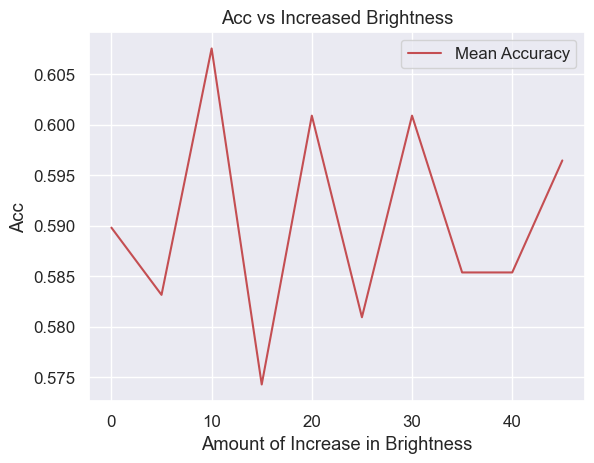

In [24]:
#Test the accuracy with test data after increasing the image brightness
class AdjustBrightness(object):
    def __init__(self, bright=0.):
        self.bright = bright
        
    def __call__(self, tensor):
        img = np.array(tensor)
        #print(img)
        # extend the tensor value from (0,1) to (0,255)
        img = img * 255 
        #print(img)
        # adjust the brightness, and limit the pixel range in (0,255)
        img = np.clip(img + self.bright, 0, 255)
        
        img_tensor = torch.from_numpy(img/255)
        return img_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(brightness={0})'.format(self.bright)

acc_bright = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

bright_change = [ 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
model_ft = model_ft.to(device)

for bright in bright_change:
    model_ft.load_state_dict(best_model_wts)

    brightness_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AdjustBrightness(bright),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_brightness_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), brightness_transform)

    testloader_brightness = torch.utils.data.DataLoader(test_brightness_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_brightness):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with image brightness increased by {0} on the test images: {1:.2f}'.format(
        bright ,100 * correct / total))
    acc_bright.append(correct / total)

print(acc_bright)
plt.figure(1)
plt.title("Acc vs Increased Brightness")
plt.xlabel('Amount of Increase in Brightness')
plt.ylabel('Acc')
plt.plot(bright_change,acc_bright,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_bright_in.jpg')
plt.show()

Accuracy with image brightness decreased by 0 on the test images: 59.42
Accuracy with image brightness decreased by 5 on the test images: 57.87
Accuracy with image brightness decreased by 10 on the test images: 59.20
Accuracy with image brightness decreased by 15 on the test images: 58.98
Accuracy with image brightness decreased by 20 on the test images: 60.75
Accuracy with image brightness decreased by 25 on the test images: 59.42
Accuracy with image brightness decreased by 30 on the test images: 58.31
Accuracy with image brightness decreased by 35 on the test images: 58.09
Accuracy with image brightness decreased by 40 on the test images: 58.54
Accuracy with image brightness decreased by 45 on the test images: 55.21
[0.5942350332594235, 0.5787139689578714, 0.5920177383592018, 0.5898004434589801, 0.6075388026607539, 0.5942350332594235, 0.5831485587583148, 0.5809312638580931, 0.5853658536585366, 0.5521064301552107]


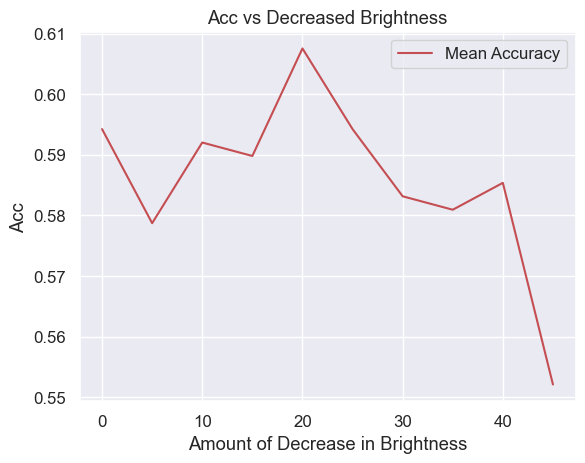

In [26]:
#Test the accuracy with test data after decreasing the image brightness
acc_bright_de = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

bright_change_de = [ 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
model_ft = model_ft.to(device)

for bright in bright_change_de:
    model_ft.load_state_dict(best_model_wts)
    bright_de = -bright # decrease the brightness by adding negative values
    brightness_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AdjustBrightness(bright_de),  
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_brightness_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), brightness_transform)

    testloader_brightness = torch.utils.data.DataLoader(test_brightness_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_brightness):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with image brightness decreased by {0} on the test images: {1:.2f}'.format(
        bright ,100 * correct / total))
    acc_bright_de.append(correct / total)

print(acc_bright_de)
plt.figure(1)
plt.title("Acc vs Decreased Brightness")
plt.xlabel('Amount of Decrease in Brightness')
plt.ylabel('Acc')
plt.plot(bright_change_de,acc_bright_de,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_bright_de.jpg')
plt.show()

Accuracy with random occlusion of size 0 on the test images: 57.43
Accuracy with random occlusion of size 5 on the test images: 58.09
Accuracy with random occlusion of size 10 on the test images: 59.20
Accuracy with random occlusion of size 15 on the test images: 57.65
Accuracy with random occlusion of size 20 on the test images: 60.53
Accuracy with random occlusion of size 25 on the test images: 59.65
Accuracy with random occlusion of size 30 on the test images: 60.53
Accuracy with random occlusion of size 35 on the test images: 59.42
Accuracy with random occlusion of size 40 on the test images: 55.65
Accuracy with random occlusion of size 45 on the test images: 58.98
[0.5742793791574279, 0.5809312638580931, 0.5920177383592018, 0.5764966740576497, 0.6053215077605322, 0.5964523281596452, 0.6053215077605322, 0.5942350332594235, 0.5565410199556541, 0.5898004434589801]


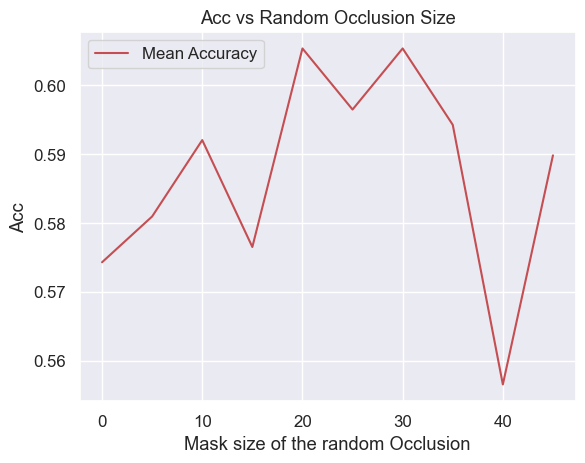

In [27]:
#Test the accuracy with test data after adding random occlusion
class AddRandomOcclusion(object):
    def __init__(self, size=0.):
        self.size = size
        
    def __call__(self, tensor):
        img = np.array(tensor)
        # randomly choose occlusion region
        n,r,c = img.shape
        row_start = random.randint(0,r-self.size)
        column_start = random.randint(0,c-self.size)

        # set occlusion region to black with pixel value of (0,0,0) in RGB channel
        for i in range(n):
            for j in range(row_start,row_start+self.size-1):
                for k in range(column_start,column_start+self.size-1):
                    img[i][j][k] = 0
        #print(img)
        img_tensor = torch.from_numpy(img)
        return img_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)

acc_occ = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

sizes = [ 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
model_ft = model_ft.to(device)

for size in sizes:
    model_ft.load_state_dict(best_model_wts)

    occlusion_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AddRandomOcclusion(size),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_occlusion_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), occlusion_transform)

    testloader_occlusion = torch.utils.data.DataLoader(test_occlusion_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_occlusion):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with random occlusion of size {0} on the test images: {1:.2f}'.format(
        size ,100 * correct / total))
    acc_occ.append(correct / total)

print(acc_occ)
plt.figure(1)
plt.title("Acc vs Random Occlusion Size")
plt.xlabel('Mask size of the random Occlusion')
plt.ylabel('Acc')
plt.plot(sizes,acc_occ,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_occlusion.jpg')
plt.show()

Accuracy with s&p noise of amount 0.0 on the test images: 58.76
Accuracy with s&p noise of amount 0.02 on the test images: 56.10
Accuracy with s&p noise of amount 0.04 on the test images: 52.11
Accuracy with s&p noise of amount 0.06 on the test images: 52.99
Accuracy with s&p noise of amount 0.08 on the test images: 51.66
Accuracy with s&p noise of amount 0.1 on the test images: 51.44
Accuracy with s&p noise of amount 0.12 on the test images: 49.89
Accuracy with s&p noise of amount 0.14 on the test images: 46.34
Accuracy with s&p noise of amount 0.16 on the test images: 49.22
Accuracy with s&p noise of amount 0.18 on the test images: 44.57
[0.5875831485587583, 0.5609756097560976, 0.5210643015521065, 0.5299334811529933, 0.516629711751663, 0.5144124168514412, 0.49889135254988914, 0.4634146341463415, 0.49223946784922396, 0.44567627494456763]


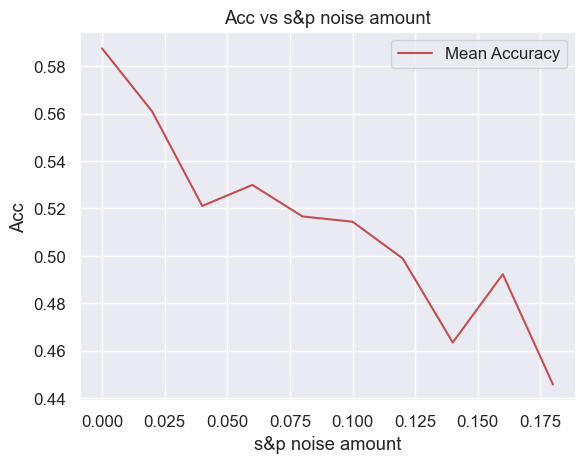

In [28]:
#Test the accuracy with test data after adding salt and pepper pixel noise
class AddSaltAndPepperNoise(object):
    def __init__(self, amount=0.):
        self.amount = amount
        
    def __call__(self, tensor):
        # add salt and pepper noise
        img_sp_noise = random_noise(np.array(tensor), mode='s&p', seed=None, clip=True, amount=self.amount)
        # convert to integers in range (0..255)
        img_sp_noise = (255*img_sp_noise).astype(np.uint16)
        # convert to type 'float' as required by following functions 
        img_sp_noise = (img_sp_noise).astype(np.float32)
        # finally convert to values in range (0,1) for futher tensor process
        tensor_new = torch.from_numpy(img_sp_noise/255)
        return tensor_new

    def __repr__(self):
        return self.__class__.__name__ + '(amount={0})'.format(self.amount)


amount_sp = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
acc_sp = []

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )

model_ft = model_ft.to(device)

for amount in amount_sp:
    model_ft.load_state_dict(best_model_wts)

    sp_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            AddSaltAndPepperNoise(amount=amount),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    test_sp_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), sp_transform)

    testloader_sp = torch.utils.data.DataLoader(test_sp_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader_sp):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy with s&p noise of amount {0} on the test images: {1:.2f}'.format(
        amount,100 * correct / total))
    acc_sp.append(correct / total)

print(acc_sp)
plt.figure(1)
plt.title("Acc vs s&p noise amount")
plt.xlabel('s&p noise amount')
plt.ylabel('Acc')
plt.plot(amount_sp,acc_sp,color = 'r', label="Mean Accuracy")
plt.legend()
plt.savefig('cnn_sp.jpg')
plt.show()